<a href="https://colab.research.google.com/github/bnv20/cakd3/blob/main/dl_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델을 만들어 보죠:

In [42]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights= 'imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# 데이터 증식을 사용하지 않는 빠른 특성 추출

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/cakd3_colab/dl_keras/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count,4,4,512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i+1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features.shape
validation_features.shape

(1000, 4, 4, 512)

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features,(1000,4*4*512))

In [ ]:
train_features.shape

(2000, 8192)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss='binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features,validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 1s 4ms/step - loss: 0.4870 - acc: 0.8020 - val_loss: 0.3941 - val_acc: 0.8550
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3378 - acc: 0.8705 - val_loss: 0.3181 - val_acc: 0.8820
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2787 - acc: 0.8975 - val_loss: 0.2879 - val_acc: 0.8910
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2435 - acc: 0.9085 - val_loss: 0.2744 - val_acc: 0.8900
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2197 - acc: 0.9265 - val_loss: 0.2598 - val_acc: 0.8980
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1982 - acc: 0.9275 - val_loss: 0.2545 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1814 - acc: 0.9415 - val_loss: 0.2499 - val_acc: 0.9040
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

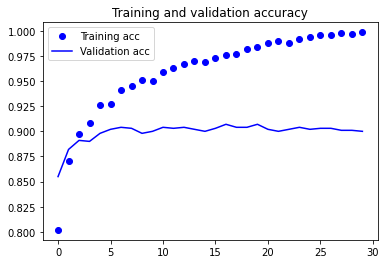

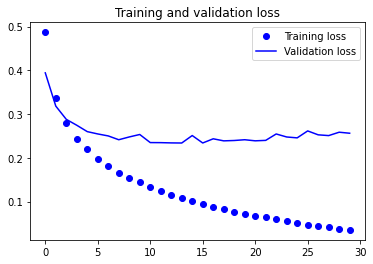

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo',label='Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [43]:
# 데이터 증식 기법 사용

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [44]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights= 'imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [45]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:',
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [46]:
conv_base.trainable = False

In [47]:
print('conv_base를 동결한 후 훈련되는 가중치의 수: ',
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수:  4


In [48]:
import os
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

base_dir = '/content/drive/MyDrive/cakd3_colab/dl_keras/datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
model.compile(loss = 'binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 18s - loss: 0.5616 - acc: 0.7240 - val_loss: 0.4278 - val_acc: 0.8380
Epoch 2/30
100/100 - 18s - loss: 0.4202 - acc: 0.8260 - val_loss: 0.3441 - val_acc: 0.8660
Epoch 3/30
100/100 - 18s - loss: 0.3662 - acc: 0.8520 - val_loss: 0.3084 - val_acc: 0.8710
Epoch 4/30
100/100 - 18s - loss: 0.3340 - acc: 0.8635 - val_loss: 0.2873 - val_acc: 0.8900
Epoch 5/30
100/100 - 17s - loss: 0.3034 - acc: 0.8740 - val_loss: 0.2867 - val_acc: 0.8830
Epoch 6/30
100/100 - 18s - loss: 0.3059 - acc: 0.8730 - val_loss: 0.2615 - val_acc: 0.8930
Epoch 7/30
100/100 - 18s - loss: 0.2871 - acc: 0.8810 - val_loss: 0.2552 - val_acc: 0.8980
Epoch 8/30
100/100 - 18s - loss: 0.2711 - acc: 0.8870 - val_loss: 0.2496 - val_acc: 0.9000
Epoch 9/30
100/100 - 18s - loss: 0.2622 - acc: 0.8960 - val_loss: 0.2514 - val_acc: 0.8990
Epoch 10/30
100/100 - 17s - loss: 0.2554 - acc: 0.8995 - val_loss: 0.2413 - val_acc: 0.9010
Epoch

In [50]:
model.save('/content/drive/MyDrive/cakd3_colab/dl_keras/cats_and_dogs_small_3.h5')

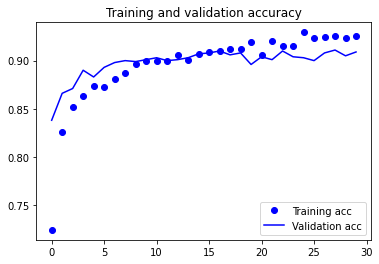

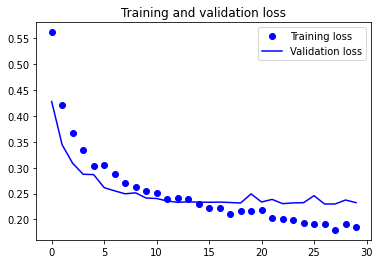

In [51]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [53]:
# 미세조정

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


In [54]:
model.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 19s 183ms/step - loss: 0.1937 - acc: 0.9200 - val_loss: 0.2242 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1680 - acc: 0.9325 - val_loss: 0.2324 - val_acc: 0.9050
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1411 - acc: 0.9420 - val_loss: 0.2579 - val_acc: 0.8940
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.1249 - acc: 0.9520 - val_loss: 0.2096 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 0.1074 - acc: 0.9595 - val_loss: 0.2383 - val_acc: 0.9120
Epoch 6/100
100/100 [==============================] - 18s 180ms/step - loss: 0.0935 - acc: 0.9680 - val_loss: 0.2186 - val_acc: 0.9310
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 0.0849 - acc: 0.9685 - val_loss: 0.2364 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

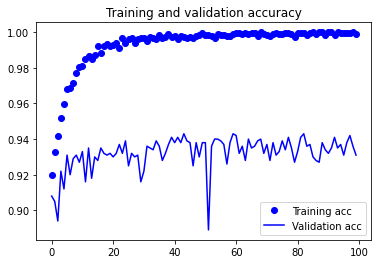

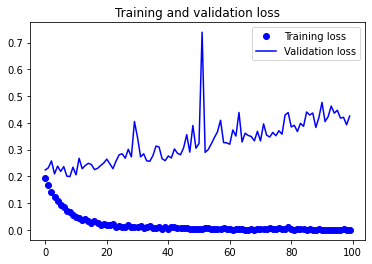

In [55]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

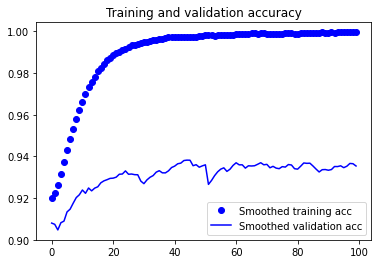

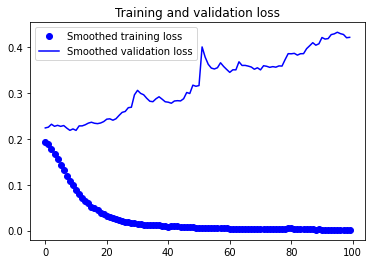

In [56]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 413s 8s/step - loss: 0.4782 - acc: 0.9320
test acc: 0.9319999814033508


93%의 테스트 정확도

## 정리

다음은 앞의 두 절에 있는 예제로부터 배운 것들입니다.

* 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
* 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
* 특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
* 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.
